##  In this notebook we build different kinds of quantum trajectories. We will be primairly interested in:

1. Kerr in qubit regime

2. Kerr in bistable regime

3. Atom bistability (see notebook "make_quantum_trajectories-absorptive_bistability").

We will also be interested in the transition between the first and second regimes of the Kerr system.

I store trajectory files as *.pkl files or *.mat files. This way I can easily load them into another notebook, or load the trajectories to matlab.

In [2]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [3]:
####
####

### Select Regime from "kerr_qubit", "kerr_bistable", "intermediate_state"
### TODO: implement a regime "transition_kerr" which increases the drive periodically, or stochastically, etc.

Regime = "kerr_bistable"

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True
file_name_mat = './trajectory_data/mat_' + Regime

## pkl file (can be loaded in python) in the same format as above.
save_pkl = True
file_name_pkl = './trajectory_data/pkl_' + Regime

## pkl file with only the state and parameters. Split into real and imaginary components. 
save_pkl_psi_only = True
file_name = './trajectory_data/' + Regime

####
####

In [4]:
import matplotlib as mil
mil.use('TkAgg')


In [5]:
## QHDL package
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace
from sympy import sqrt


## qutip 
import qutip as qt

## numpy
import numpy as np

## plotting
%matplotlib inline
import matplotlib.pyplot as plt

## pickle
import pickle

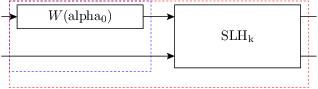

10.0%. Run time:   8.46s. Est. time left: 00:00:01:16
20.0%. Run time:  16.68s. Est. time left: 00:00:01:06
30.0%. Run time:  25.39s. Est. time left: 00:00:00:59
40.0%. Run time:  34.67s. Est. time left: 00:00:00:51
50.0%. Run time:  43.90s. Est. time left: 00:00:00:43
60.0%. Run time:  54.05s. Est. time left: 00:00:00:36
70.0%. Run time:  64.13s. Est. time left: 00:00:00:27
80.0%. Run time:  74.85s. Est. time left: 00:00:00:18
90.0%. Run time:  85.36s. Est. time left: 00:00:00:09
100.0%. Run time:  95.83s. Est. time left: 00:00:00:00
Total run time:  95.93s


In [13]:
# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

if Regime == "kerr_bistable":
    ## bistable regime
    params = {alpha0 : 52.467, chi : -106.066, Delta : 750., kappa_1 : 220, kappa_2 : 0,
              'Ntraj' : 1000, 'duration' : 100., 'Nfock' : 15}
elif Regime == "kerr_qubit":
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 0., kappa_1 : 0.5, kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 5000., 'Nfock' : 15}
elif Regime == "intermediate_state":
    params = {alpha0 : 100.0, chi : -20.0, Delta : 0, kappa_1 : 1., kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}
else:
    raise ValueError("Unknown regime, or not implemented yet.")
    
## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']


# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_num = SYS.substitute(params)

SYS_num.space.dimension = Nfock
psi0 = qt.coherent(Nfock, 0)
Tsim = np.arange(0, duration/1000, 1e-3)

H_num, L_num = SYS_num.HL_to_qutip()

## Observables

obs = [a_k.dag()*a_k, a_k+a_k.dag(), (a_k-a_k.dag())/1j]
obsq = [o.to_qutip(full_space = SYS_num.space) for o in obs]

## generate trajectory
mcdata = qt.mcsolve(H_num, psi0, Tsim, L_num, 
                       obsq, ntraj=Ntraj, 
                       options=qt.Odeoptions(store_states=True,average_expect=False))



In [14]:
SYS

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('k', ''))))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('k', '')))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(alpha_0*sqrt(kappa_1), Create(LocalSpace('k', ''))), ScalarTimesOperator(-sqrt(kappa_1)*conjugate(alpha_0), Destroy(LocalSpace('k', ''))))), ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('k', '')), Create(LocalSpace('k', '')), Destroy(LocalSpace('k', '')), Destroy(LocalSpace('k', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('k', '')), Destroy(LocalSpace('k', ''))))))

In [15]:
# N_num = qt.num(Nfock)

# a = qt.destroy(Nfock)
# E = a+a.dag()

# f, a = plt.subplots(figsize=(24,5))
# plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
# plt.tick_params(labelsize=17)


# for i in range(Ntraj): 
#     a.plot(mcdata.times[0:int(duration)], qt.expect(N_num, mcdata.states[i])[0:int(duration)], "b", alpha=0.3)

# a.plot(mcdata.times[0:int(duration)],
#        np.average(np.asarray([qt.expect(N_num, mcdata.states[i])[0:int(duration)] for i in range(Ntraj)]),axis = 0),
#        c='black'
#       )


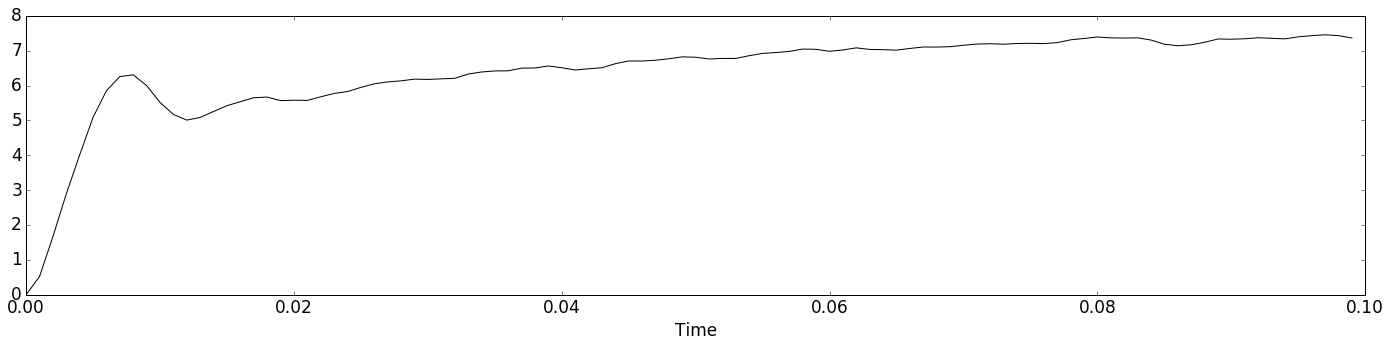

In [16]:
N_num = qt.num(Nfock)

a = qt.destroy(Nfock)
E = a+a.dag()

f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


# for i in range(Ntraj): 
#     a.plot(mcdata.times[0:int(duration)], qt.expect(N_num, mcdata.states[i])[0:int(duration)], "b", alpha=0.3)

a.plot(mcdata.times[0:int(duration)],
       np.average(np.asarray([qt.expect(N_num, mcdata.states[i])[0:int(duration)] for i in range(Ntraj)]),axis = 0),
       c='black'
      )


In [17]:
if save_pkl_psi_only:
    ## Take the trajectory data and extract the vectors in the Hilbert space.
    ## here we double-up the resulting coordiantes, i.e. separate each state into a 
    ## real and imaginary part.

    def make_p_complex():
        p = []
        for traj in mcdata.states:
            for k in range(0,len(traj)):
                val = np.asarray( traj[k].data.todense().T )[0]
                val_doubled = np.concatenate([val.real,val.imag])
                p.append(val_doubled)
        p = np.asarray(p)
        return p

    p2=make_p_complex()

    ## Save the p2 for other notebooks
    output = open(file_name + ".pkl", 'wb')
    pickle.dump((params,SLH,p2), output)
    output.close()

In [18]:
## save as matlab or pkl file

from mcdata2matfile_or_pkl import mcdata2matfile_or_pkl

if save_mat:
    mcdata2matfile_or_pkl(mcdata, file_name_mat, obs, save_mat = True, save_pkl = False)    
if save_pkl:
    mcdata2matfile_or_pkl(mcdata, file_name_pkl, obs, save_mat = False, save_pkl = True, params=params)

/Users/gil/Documents/repos/diffusion_map/trajectory_data/mat_kerr_bistable.mat

/Users/gil/Documents/repos/diffusion_map/trajectory_data/pkl_kerr_bistable.pkl